# CAM类激活热力图可解释性分析

调用MMClassification预训练图像分类模型，对单张图像进行图像分类预测，生成CAM类别激活热力图，进行可解释性分析。

同济子豪兄：https://space.bilibili.com/1900783

参考教程：https://mp.weixin.qq.com/s?__biz=MzI4MDcxNTY2MQ==&mid=2247485910&idx=1&sn=22aa21397b003cf40af279ae3acccac1&chksm=ebb50134dcc288220d3f941bcd8b613494c7e1371435e909c9f6e522c21e194f50c7b68f4cc4&token=1125533908&lang=zh_CN#rd

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

2022-8-16

## 进入 mmclassification 目录

In [1]:
import os
os.chdir('mmclassification')

## 设置matplotlib中文字体

In [2]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [ ]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2022-08-17 11:31:34--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Unable to establish SSL connection.


## 导入工具包

In [5]:
import pandas as pd
import numpy as np

import torch

import cv2
from PIL import Image

import mmcv
from mmcls.apis import init_model, inference_model, show_result_pyplot

import matplotlib.pyplot as plt
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入ImageNet 1000图像分类中文标签

In [6]:
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
labels_to_idx = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['Chinese']
    labels_to_idx[row['Chinese']] = row['ID']

In [7]:
# labels_to_idx

## 生成CAM类激活热力图

类别与ID：

边牧犬 232

牧羊犬 231

虎斑猫 282、281

网球 852


In [8]:
!python tools/visualizations/vis_cam.py \
        test_img/cat_dog.jpg \
        configs/resnet/resnet18_8xb32_in1k.py \
        checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth \
        --target-category 281 \
        --method GradCAM \
        --save-path cam.jpg

load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
Automatically choose the last norm layer as target_layer.


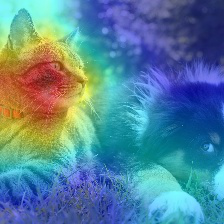

In [9]:
Image.open('cam.jpg')

## 对Transformer结构的模型，需加`--vit-like`参数

In [10]:
!python tools/visualizations/vis_cam.py \
        test_img/cat_dog.jpg \
        configs/swin_transformer/swin-tiny_16xb64_in1k.py \
        checkpoints/swin_tiny_224_b16x64_300e_imagenet_20210616_090925-66df6be6.pth \
        --target-category 281 \
        --method GradCAM \
        --save-path cam.jpg \
        --vit-like

load checkpoint from local path: checkpoints/swin_tiny_224_b16x64_300e_imagenet_20210616_090925-66df6be6.pth
Automatically choose the last norm layer as target_layer.


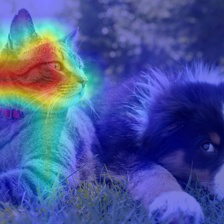

In [11]:
Image.open('cam.jpg')

## 批量生成各种类别、各种方法的热力图

In [11]:
# 创建文件夹
# os.mkdir('cam_images_imagenet')

In [9]:
fruits = ['边境牧羊犬', '牧羊犬', '山猫,虎猫', '虎斑猫', '网球']
methods = ['GradCAM', 'GradCAM++', 'XGradCAM', 'EigenCAM', 'EigenGradCAM', 'LayerCAM']

In [10]:
for fruit in fruits:
    fruit_id = labels_to_idx[fruit]
    n = len(methods)
    
    for idx, method in enumerate(methods):
        # 生成 CAM 图保存路径
        img_path = 'cam_images_imagenet/{}_{}.jpg'.format(fruit, method)
        
        # 运行命令行，保存图像
        prompt = '''
        python tools/visualizations/vis_cam.py \
        test_img/cat_dog.jpg \
        configs/resnet/resnet18_8xb32_in1k.py \
        checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth \
        --target-category {} \
        --method {} \
        --save-path {}
        '''.format(fruit_id, method, img_path)
        os.system(prompt)
        
        print('图像已保存', img_path)
print('CAM图像生成完成')

load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/边境牧羊犬_GradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/边境牧羊犬_GradCAM++.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/边境牧羊犬_XGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/边境牧羊犬_EigenCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/边境牧羊犬_EigenGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/边境牧羊犬_LayerCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/牧羊犬_GradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/牧羊犬_GradCAM++.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/牧羊犬_XGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/牧羊犬_EigenCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/牧羊犬_EigenGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/牧羊犬_LayerCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/山猫,虎猫_GradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/山猫,虎猫_GradCAM++.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/山猫,虎猫_XGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/山猫,虎猫_EigenCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/山猫,虎猫_EigenGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/山猫,虎猫_LayerCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/虎斑猫_GradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/虎斑猫_GradCAM++.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/虎斑猫_XGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/虎斑猫_EigenCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/虎斑猫_EigenGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/虎斑猫_LayerCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/网球_GradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/网球_GradCAM++.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/网球_XGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/网球_EigenCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/网球_EigenGradCAM.jpg
load checkpoint from local path: checkpoints/resnet18_batch256_imagenet_20200708-34ab8f90.pth
Automatically choose the last norm layer as target_layer.


/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


图像已保存 cam_images_imagenet/网球_LayerCAM.jpg
CAM图像生成完成


In [12]:
# os.chdir('cam_images_imagenet')

In [8]:
os.listdir('cam_images_imagenet')

['边境牧羊犬_GradCAM.jpg',
 '边境牧羊犬_GradCAM++.jpg',
 '边境牧羊犬_XGradCAM.jpg',
 '边境牧羊犬_EigenCAM.jpg',
 '边境牧羊犬_EigenGradCAM.jpg',
 '边境牧羊犬_LayerCAM.jpg',
 '牧羊犬_GradCAM.jpg',
 '牧羊犬_GradCAM++.jpg',
 '牧羊犬_XGradCAM.jpg',
 '牧羊犬_EigenCAM.jpg',
 '牧羊犬_EigenGradCAM.jpg',
 '牧羊犬_LayerCAM.jpg',
 '山猫,虎猫_GradCAM.jpg',
 '山猫,虎猫_GradCAM++.jpg',
 '山猫,虎猫_XGradCAM.jpg',
 '山猫,虎猫_EigenCAM.jpg',
 '山猫,虎猫_EigenGradCAM.jpg',
 '山猫,虎猫_LayerCAM.jpg',
 '虎斑猫_GradCAM.jpg',
 '虎斑猫_GradCAM++.jpg',
 '虎斑猫_XGradCAM.jpg',
 '虎斑猫_EigenCAM.jpg',
 '.ipynb_checkpoints',
 '虎斑猫_EigenGradCAM.jpg',
 '虎斑猫_LayerCAM.jpg',
 '网球_GradCAM.jpg',
 '网球_GradCAM++.jpg',
 '网球_XGradCAM.jpg',
 '网球_EigenCAM.jpg',
 '网球_EigenGradCAM.jpg',
 '网球_LayerCAM.jpg']

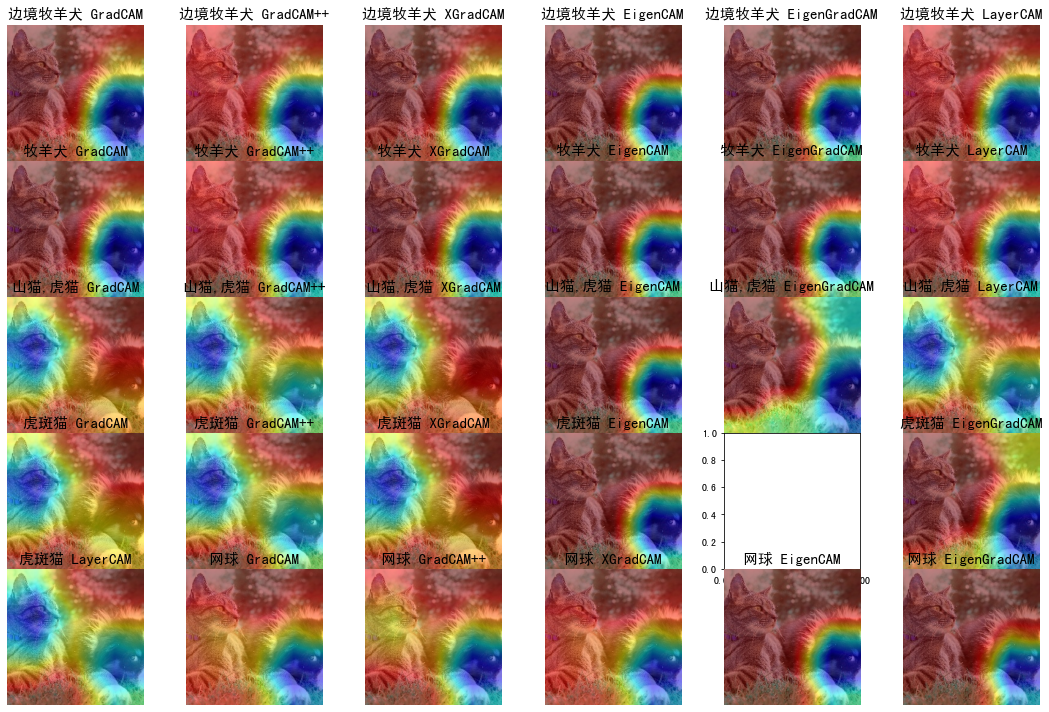

In [18]:
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(os.listdir('cam_images_imagenet')):
    
        plt.subplot(len(fruits), 6, i+1)
        fruit = img_path.split('_')[0]
        method = img_path.split('_')[1].split('.')[0]
        try:
            img_array = cv2.imread(os.path.join('cam_images_imagenet', img_path))
        except:
            
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(fruit + ' ' + method, fontsize=15)
    except:
        pass

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=2)#调整子图间距
plt.show()